1、数据探索

In [28]:
# 对数据进行基本的探索
# 返回缺失值个数以及最大最小值
import pandas as pd
# 航空原始数据,第一行为属性标签
datafile='./data/air_data.csv'
# 数据探索结果表
resultfile='./temp/explore.csv'
# 读取原始数据，指定UTF-8编码（需要用文本编辑器将数据装换为UTF-8编码）
data=pd.read_csv(datafile,encoding='utf-8')
# 包括对数据的基本描述，percentiles参数是指定计算多少的分位数表（如1/4分位数、中位数等）
# T是转置，转置后更方便查阅
explore=data.describe(percentiles = [], include ='all').T
# describe()函数自动计算非空值数，需要手动计算空值数
explore['null']=len(data)-explore['count']
explore=explore[['null','max','min']]
# 表头重命名
explore.columns=[u'空值数',u'最大值',u'最小值']
'''
这里只选取部分探索结果。
describe()函数自动计算的字段有count(非空值数)、unique(唯一值数)、top(频数最高者)、
freq(最高频数)、mean(平均值)、std(方差)、min(最小值)、50%(中位数)、max(最大值)
'''
# 导出结果
explore.to_csv(resultfile,encoding='utf-8-sig')

2、数据清洗

In [29]:
import numpy as np
import pandas as pd
airline_data = pd.read_csv('./data/air_data.csv')
print('原始数据的形状为：',airline_data.shape)
# 数据清洗结果表
cleanfile="./temp/data_cleaned.csv"
# 去除票价为空的记录
exp1 = airline_data["SUM_YR_1"].notnull()
exp2 = airline_data["SUM_YR_2"].notnull()
exp = exp1 & exp2
airline_notnull = airline_data.loc[exp,:]
print('删除缺失记录后数据的形状为：',airline_notnull.shape)
#只保留票价非零的，平均折扣率不为0且总飞行公里数大于0的记录。
index1 = airline_notnull['SUM_YR_1'] != 0
index2 = airline_notnull['SUM_YR_2'] != 0
index3 = (airline_notnull['SEG_KM_SUM']> 0) & (airline_notnull['avg_discount'] != 0) 
airline = airline_notnull[(index1 | index2) & index3]
print('删除异常记录后数据的形状为：',airline.shape)
# 导出结果
airline_notnull.to_csv(cleanfile,encoding='utf-8-sig')
airline_notnull.head(5)

原始数据的形状为： (62988, 44)
删除缺失记录后数据的形状为： (62299, 44)
删除异常记录后数据的形状为： (62044, 44)


,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/02,2008/12/24,男,6,.,北京,CN,31.0,2014/03/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/02/19,2007/08/03,男,6,NaN,北京,CN,42.0,2014/03/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/02/01,2007/08/30,男,6,.,北京,CN,40.0,2014/03/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/08/22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014/03/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/04/10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014/03/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


3、属性规约

In [30]:
# 选取并构建LRFMC模型的特征
# 选取需求特征
airline_selection = airline[["FFP_DATE","LOAD_TIME",
    "FLIGHT_COUNT","LAST_TO_END",
    "avg_discount","SEG_KM_SUM"]]
# 构建L特征
L = pd.to_datetime(airline_selection["LOAD_TIME"]) - pd.to_datetime(airline_selection["FFP_DATE"])
L = L.astype("str").str.split().str[0]
L = L.astype("int")/30
# 合并特征
airline_features = pd.concat([L, airline_selection.iloc[:,2:]], axis = 1)
print('构建的LRFMC特征前5行为: \n',airline_features.head())

构建的LRFMC特征前5行为: 
            0  FLIGHT_COUNT  LAST_TO_END  avg_discount  SEG_KM_SUM
0  90.200000           210            1      0.961639      580717
1  86.566667           140            7      1.252314      293678
2  87.166667           135           11      1.254676      283712
3  68.233333            23           97      1.090870      281336
4  60.533333           152            5      0.970658      309928


In [31]:
# 标准化LRFMC模型的特征
from sklearn.preprocessing import StandardScaler
data = StandardScaler().fit_transform(airline_features)
np.savez('./temp/airline_scale.npz',data) 
print('标准化后LRFMC五个特征为: \n',data[:5,:])

标准化后LRFMC五个特征为: 
 [[ 1.43571897 14.03412875 -0.94495516  1.29555058 26.76136996]
 [ 1.30716214  9.07328567 -0.9119018   2.86819902 13.1269701 ]
 [ 1.32839171  8.71893974 -0.88986623  2.88097321 12.65358345]
 [ 0.65848092  0.78159082 -0.41610151  1.99472974 12.54072306]
 [ 0.38603481  9.92371591 -0.92291959  1.3443455  13.89884778]]


4、数据变换——标准化

In [32]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# 需要进行标准化的数据文件
datafile = './data/zscoredata.xls'
# 标准差化后的数据存储路径文件
zscoredfile = './temp/zscoreddata.xls'
# 标准化处理
data = pd.read_excel(datafile)
# 简洁的语句实现了标准化变换，类似地可以实现任何想要的变换
data = (data - data.mean(axis=0))/(data.std(axis=0))
# 表头重命名
data.columns = ['Z'+i for i in data.columns]
# 数据写入
data.to_excel(zscoredfile, index=False)

5.1、KMeans聚类

In [33]:
# K-Means聚类算法
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
# 读取标准化后的数据
airline_scale=np.load('./temp/airline_scale.npz')['arr_0']
# 确定聚类中心数
k=5
# 构建模型，随机种子设为 123
kmeans_model=KMeans(n_clusters=k,random_state=123)
# 模型训练
fit_kmeans=kmeans_model.fit(airline_scale)
# 查看聚类结果
kmeans_cc=kmeans_model.cluster_centers_ 
print('各类聚类中心为：\n',kmeans_cc)
kmeans_labels=kmeans_model.labels_ 
print('各样本的类别标签为：\n',kmeans_labels)
r1=pd.Series(kmeans_model.labels_).value_counts()
print('最终每个类别的数目为：\n',r1)
# 输出聚类分群的结果
# 将聚类中心放在数据框中
cluster_center=pd.DataFrame(kmeans_model.cluster_centers_,columns=['ZL','ZR','ZF','ZM','ZC'])
# 将样本类别作为数据框索引
cluster_center.index=pd.DataFrame(kmeans_model.labels_ ).drop_duplicates().iloc[:,0]
print(cluster_center)

各类聚类中心为：
 [[ 1.16094184e+00 -8.66355853e-02 -3.77438378e-01 -1.56893014e-01
  -9.45420456e-02]
 [ 4.83551752e-01  2.48315495e+00 -7.99413281e-01  3.09787292e-01
   2.42425727e+00]
 [ 4.07521844e-02 -2.32407891e-01 -2.32993527e-03  2.16900461e+00
  -2.36767589e-01]
 [-3.13072314e-01 -5.73910449e-01  1.68707882e+00 -1.75466654e-01
  -5.36725346e-01]
 [-7.00318428e-01 -1.60626736e-01 -4.15128221e-01 -2.58203510e-01
  -1.60330905e-01]]
各样本的类别标签为：
 [1 1 1 ... 4 3 3]
最终每个类别的数目为：
 4    24611
0    15730
3    12111
1     5337
2     4255
dtype: int64
         ZL        ZR        ZF        ZM        ZC
0                                                  
1  1.160942 -0.086636 -0.377438 -0.156893 -0.094542
2  0.483552  2.483155 -0.799413  0.309787  2.424257
0  0.040752 -0.232408 -0.002330  2.169005 -0.236768
4 -0.313072 -0.573910  1.687079 -0.175467 -0.536725
3 -0.700318 -0.160627 -0.415128 -0.258204 -0.160331


5.2、层次聚类

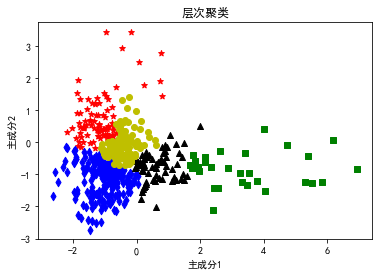

In [34]:
# 层次聚类
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca=PCA(n_components=2)
newdata=pca.fit_transform(data)

hicl=AgglomerativeClustering(n_clusters=5)
hicl_pre=hicl.fit_predict(newdata[:500])

#可视化
plt.figure()
plt.scatter(newdata[:500][hicl_pre==0,0],newdata[:500][hicl_pre==0,1],c="g",alpha=1,marker="s")
plt.scatter(newdata[:500][hicl_pre==1,0],newdata[:500][hicl_pre==1,1],c="r",alpha=1,marker="*")
plt.scatter(newdata[:500][hicl_pre==2,0],newdata[:500][hicl_pre==2,1],c="b",alpha=1,marker="d")
plt.scatter(newdata[:500][hicl_pre==3,0],newdata[:500][hicl_pre==3,1],c="k",alpha=1,marker="^")
plt.scatter(newdata[:500][hicl_pre==4,0],newdata[:500][hicl_pre==4,1],c="y",alpha=1,marker="o")
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.title("层次聚类")
plt.show()

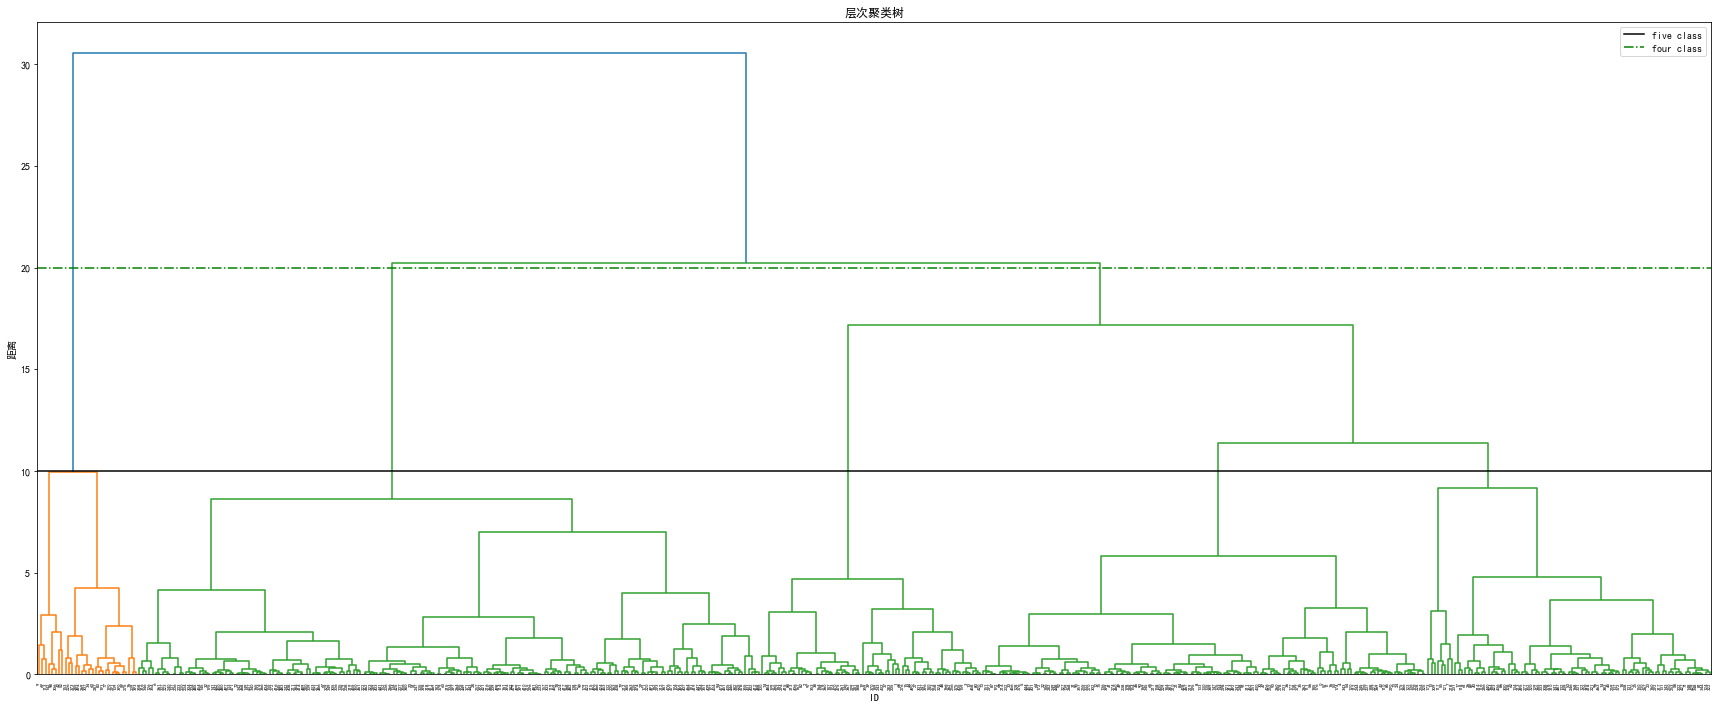

In [35]:
#绘制聚类树
from scipy.cluster.hierarchy import dendrogram,linkage
z=linkage(newdata[:500],method='ward',metric='euclidean')
fig=plt.figure(figsize=(30,12))
irisdn=dendrogram(z)
plt.axhline(y=10,color='k',linestyle='solid',label='five class')
plt.axhline(y=20,color='g',linestyle='dashdot',label='four class')
plt.title("层次聚类树")
plt.xlabel("ID")
plt.ylabel("距离")
plt.legend(loc=1)
plt.show()

5.3、DBSCAN聚类算法

[0 0 0 ... 0 0 0]


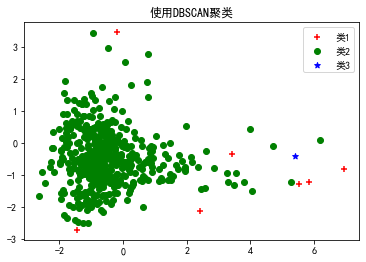

In [36]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan.fit(data)
print(dbscan.labels_)
for i in range(0,500):
    if dbscan.labels_[i]==-1:
        c1=plt.scatter(newdata[:500][i,0],newdata[:500][i,1],c='r',marker="+")
    elif dbscan.labels_[i]==0:
        c2=plt.scatter(newdata[:500][i,0],newdata[:500][i,1],c='g',marker="o")
    elif dbscan.labels_[i]==1:
        c3=plt.scatter(newdata[:500][i,0],newdata[:500][i,1],c='b',marker="*")
        
plt.legend([c1,c2,c3],['类1','类2','类3'])
plt.title("使用DBSCAN聚类")
plt.show()

最后：K-Means聚类算法绘制聚类雷达图进行客户价值分析

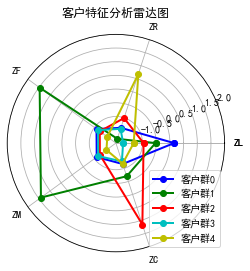

In [37]:
import pandas as pd
# 导入K均值聚类算法
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
# 待聚类的数据文件
inputfile = './temp/zscoreddata.xls'
# 需要进行的聚类类别数
k = 5
# 读取数据并进行聚类分析
data = pd.read_excel(inputfile)
# 调用k-means算法，进行聚类分析
kmodel = KMeans(n_clusters=k)
# 训练模型
kmodel.fit(data)
# 标签
labels = data.columns
# 添加多 第一个标签
labels = labels.append(pd.Index([data.columns[0]]))
plot_data = kmodel.cluster_centers_
# 指定颜色
color = ['b', 'g', 'r', 'c', 'y']
angles = np.linspace(0, 2*np.pi, k, endpoint=False)
plot_data = np.concatenate((plot_data, plot_data[:,[0]]), axis=1)
angles = np.concatenate((angles, [angles[0]]))
fig = plt.figure()
# polar参数
ax = fig.add_subplot(111, polar=True)
# 画线
for i in range(len(plot_data)):
    ax.plot(angles, plot_data[i], 'o-', color = color[i], label = u'客户群'+str(i), linewidth=2)
ax.set_rgrids(np.arange(0.01, 3.5, 0.5), np.arange(-1, 2.5, 0.5), fontproperties="SimHei")
ax.set_thetagrids(angles * 180/np.pi, labels)
plt.legend(loc = 4)
plt.title('客户特征分析雷达图')
plt.show()